# 8 kuningattaren ongelma

8 kuningattaren ongelmassa tehtävänä on ratkaista miten 8 kuningatarta voi laittaa $8×8$ ruudun shakkilaudalle ilman että yksikään kuningatar uhkaisi toista. Tässä tehtävässä tutkitaan yleisen $N$ kuningattaren ongelman ratkaisua kvanttilaskennalla.

Shakissa kuningatar pystyy liikkumaan vaakasuunnassa, pystysuunnassa ja diagonaaleilla. Ongelman mukaan kaksi kuningatarta uhkaavat toisiaan, jos ne pystyvät liikkumaan toistensa paikalle yhdessä siirrossa.

Esimerkiksi seuraava asetelma on yksi kymmenestä ratkaisusta $N$ kuningattaren ongelmaan, kun $N = 5$:

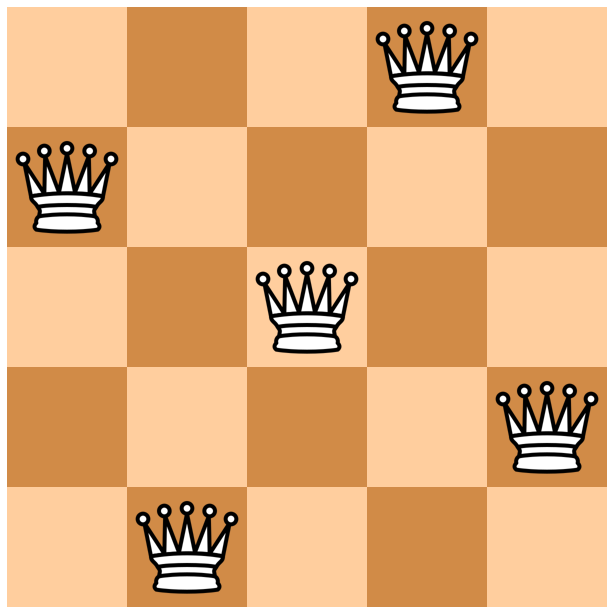

In [1]:
from numpy import matrix

# tuodaan queenvis.py tiedostosta vis funktio
from queenvis import vis

queens = matrix([
    [0, 0, 0, 1, 0],
    [1, 0, 0, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1],
    [0, 1, 0, 0, 0]
])

import matplotlib.pyplot as plt

# jos käytät vscodea ja tarvitset pimeän väriteeman niin poista # kommenttimerkki
# plt.style.use('dark_background')

# visualisoidaan kuningattaret shakkilaudalla
vis(queens)

Shakkilaudan tila esitetään $N×N$ matriisina, jossa luvut yksi ja nolla esittävät kuningatarta ja tyhjää ruutua vastaavasti.

### Tehtävä 1

Etsi jokin ratkaisu 4 kuningattaren ongelmaan ja kirjoita vastauksesi matriisimuodossa seuraavaan koodilohkoon.

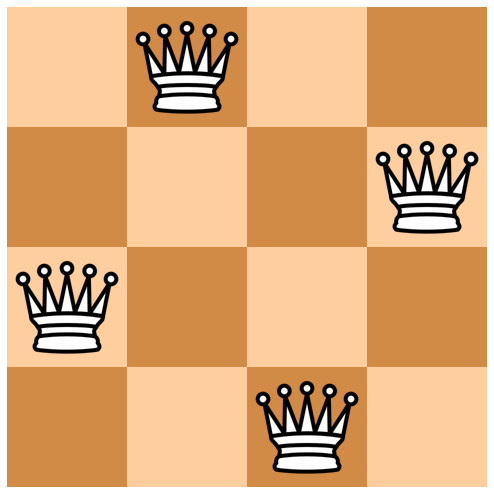

In [3]:
queens = matrix([
    [0, 1, 0, 0],    
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [0, 0, 1, 0]
])

vis(queens)

## $N$ kuningattaren ongelman ratkaisun kriteerit

Seuraavien sääntöjen tulee pitää paikkansa, jotta kuningattarien asetelma on ratkaisu:

1. Samalla rivillä voi olla korkeintaan yksi kuningatar
2. Samalla sarakkeella voi olla korkeintaan yksi kuningatar
3. Samalla diagonaalilla voi olla korkeintaan yksi kuningatar

Ensimmäinen kriteeri (rivit) voidaan ratkaista kubittien W-tilalla.

## Rivit: W-tila

W-tila on lomittuneiden kubittien muodostama symmetrinen tila. W-tila on helppo muodostaa kahdella kubitilla Hadamard-portilla ja $CNOT$:illa, mutta kolmen kubitin W-tila vaatii esimerkiksi $R_y(\theta)$-porttia tai ohjattua Hadamardia. Esimerkiksi kolmen kubitin ollessa W-tilassa, kubittien mittaus antaa yhtä suurella todennäköisyydellä (33%) jonkin seuraavista vastauksista:

$$
001 \\
010 \\
100
$$


Kolmen kubitin W-tila:

$$
\frac 1{\sqrt 3} (|001\rangle + |010\rangle + |100\rangle)
$$

$N$ kubitin W-tila on siis superpositio $N$:stä kantatilasta, joissa vain yhdestä kubitista tulee mittaustulokseksi 1 ja muista 0.

Seuraavassa ohjelmassa on muodostettu kahden kubitin W-tila, eli tila

$$
\frac 1{\sqrt 2} (|01\rangle + |10\rangle )
$$

Suorita ohjelma ja tutki simulaation tuloksia.

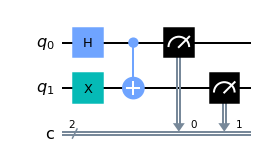

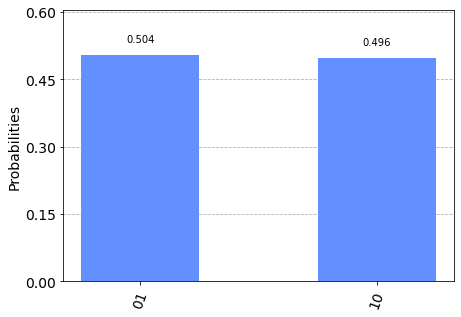

In [4]:
from qiskit import *
from qiskit.visualization import *
from qiskit.providers.aer import AerSimulator
from numpy import *
from cmath import *

qc = QuantumCircuit(2, 2)

qc.h(0)
qc.x(1)
qc.cx(0, 1)

qc.measure(0, 0)
qc.measure(1, 1)

display(qc.draw(output='mpl'))

backend = AerSimulator(method='statevector')
result = backend.run(qc).result()

plot_histogram(result.get_counts())

### Tehtävä 2

Lisää kvanttipiiriin toiset kaksi kubittia ja muodosta niiden välille myös W-tila. Mittaa myös kubitit klassiseen rekisteriin.

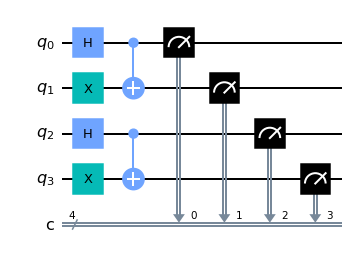

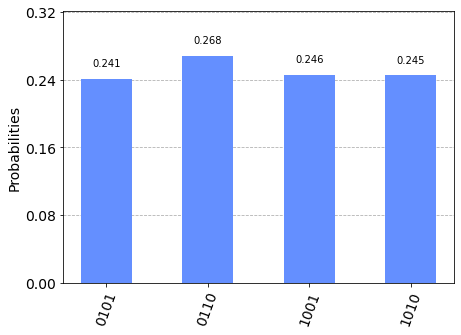

In [5]:
# TODO aseta piiriin 4 kubittia
qc = QuantumCircuit(4, 4)

qc.h(0)
qc.x(1)
qc.cx(0, 1)
# TODO kirjoita tähän kubittien 2 ja 3 W-tilan koodi, joka on sama kuin yllä mutta eri kubiteilla
qc.h(2)
qc.x(3)
qc.cx(2,3)

qc.measure(0, 0)
qc.measure(1, 1)
# TODO mittaa myös kubitit 2 ja 3 omiin bitteihin klassisessa rekisterissä
qc.measure(2, 2)
qc.measure(3, 3)


display(qc.draw(output='mpl'))

backend = AerSimulator(method='statevector')
counts = backend.run(qc).result().get_counts()

plot_histogram(counts)

> Pylväsdiagrammissa olevat mittaustulokset luettuna ylhäältä alas (eli takaperin) vastaavat kubitteja ylhäältä alas.

Piirin ylin kubitti vastaa ensimmäisen rivin ensimmäistä ruutua ja alin vastaa viimeisen rivin viimeistä ruutua, joten mittaustulokset kuvataan matriisiksi näin:

$$
abcd \mapsto \begin{bmatrix}
d && c \\
b && a
\end{bmatrix}
$$

Seuraavalla koodilohkolla voit visualisoida tulokset shakkilaudalla. Kiinnitä huomiota montako kuningatarta laudalla on, ja kuinka monta on per rivi. Tarkoituksena olisi huomata, että rivit ovat toisistaan riippumattomia, mutta kuningattaria on vain yksi per rivi eli yhteensä kaksi.

Kuvien yläpuolelle on kirjoitettu mittaustulokset jotka näkyvät myös pylväsdiagrammissa.

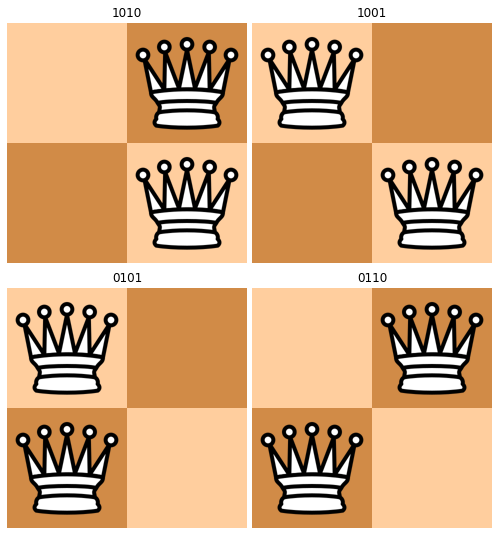

In [6]:
from numpy import array

states = []
boards = []
for state in counts:
    states.append(state)
    state = list(map(int, state))
    state.reverse() # mittaustulokset täyttävät klassisen rekisterin oikealta vasemmalle
    
    board = array(state).reshape(2, 2)
    boards.append(board)

vis(boards, states)

## Ancillat eli apukubitit

Kvanttipiirissä apukubitit auttavat tekemään monimutkaisempia operaatioita usealla kubitilla. Apukubitteja käytetään todella laajasti eri käyttötarkoituksiin ja niitä voidaan  käyttää saamaan epäsuoraa mittaustietoa kubiteista. Apukubitteja voidaan esimerkiksi flipata "virallisten" kubittien toimesta ohjatulla $X$-portilla, eli $CX$:llä.

## Sarakkeet: $CX$-portti

Ohjattu $X$-portti pyörittää kohdekubittia 180° X-akselin ympäri, jos ohjaava kubitti on tilassa 1.

Toisin kuin rivillä olevat kuningattaret, jotka muodostavat W-tilan, sarakkeella olevat kuningattaret eivät ole lomittuneet. Voisimme tehdä koko shakkilaudan kokoisen lomittuneen tilan, jossa myös sarakkeilla voi olla korkeintaan yksi kuningatar, mutta tämä vaatii erittäin paljon portteja lisää.

Apukubittia voidaan käyttää laskemaan onko sarakkeella parillinen vai pariton määrä kuningattaria tekemällä $X$ pyörityksiä yhtä monta kuin kuningattaria on.

### Tehtävä 3

Lue seuraava koodi, suorita ohjelma ja tutki simulaation tuloksia. Shakkilautojen yläpuolella on col-apukubittien mittaustulokset $[\text{col}_0, \text{col}_1, ...]$. Muuta $N = 3$ ja selitä miten apukubittien mittauksesta voidaan mitata sarakekriteerin täyttävät kuningatarasetelmat.

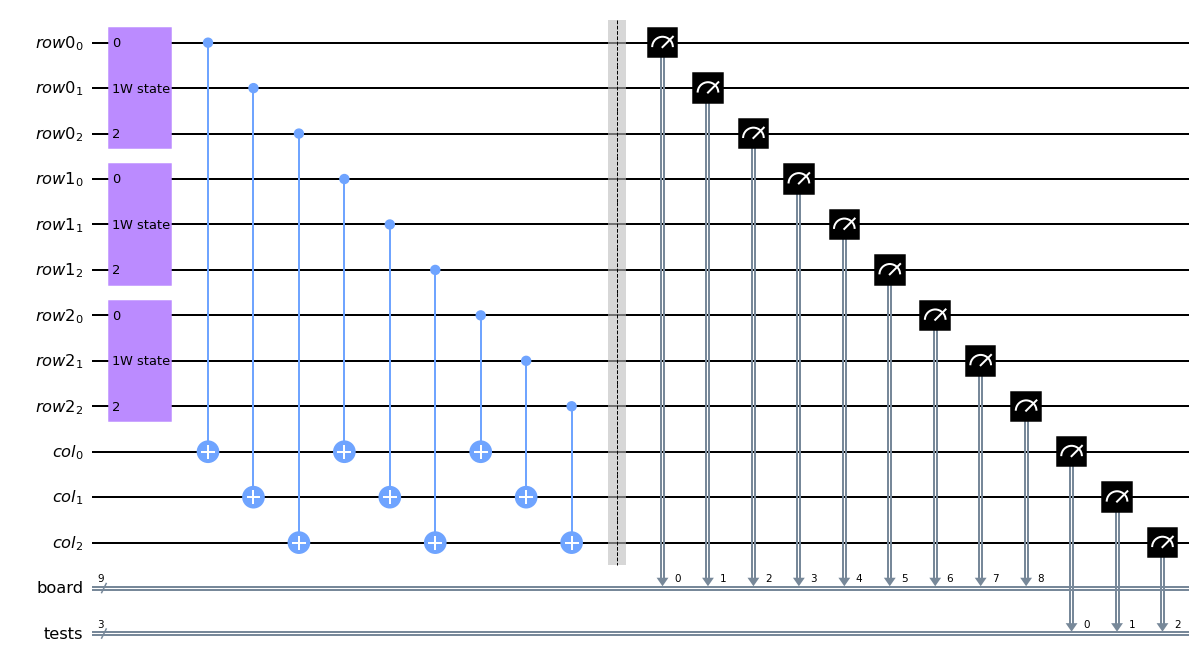

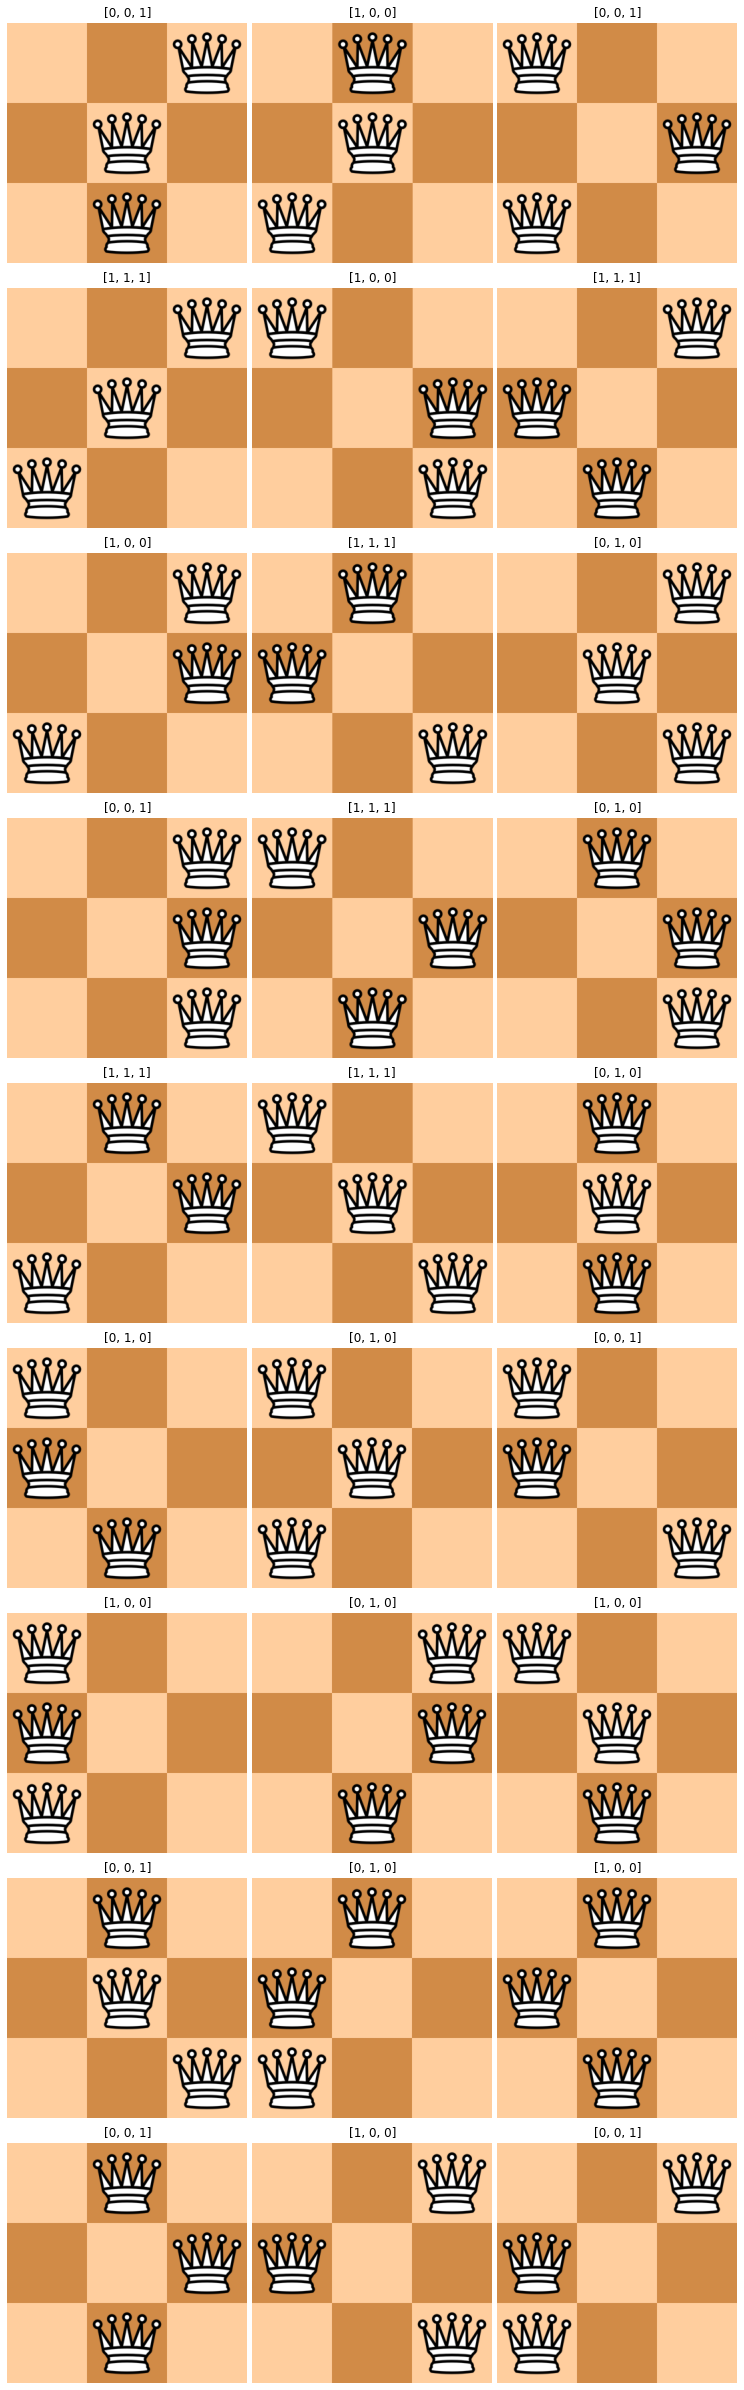

In [11]:
# tuodaan wstate.py tiedostosta funktio Wstate
from wstate import Wstate
# tuodaan utils.py tiedostosta apufunktio get_rich_counts
from utils import get_rich_counts

# katso ensiksi N = 2 tulokset, sitten muuta N = 3
N = 3

qc = QuantumCircuit()

rows = []
for n in range(N):
    row = QuantumRegister(N, f'row{n}')
    rows.append(row)
    # lisätään kvanttipiiriin N kpl N kubitin kvanttirekistereitä
    qc.add_register(row)

W = Wstate(N)
for row in rows:
    # lisätään W-alipiiri riville
    qc.append(W, row)
    
# Tähän lisättiin komento decompose
#qc = qc.decompose()

columns = QuantumRegister(N, 'col')
qc.add_register(columns)

for row in rows:
    # lisätään CX-portti jokaisen rivin kubitin ja sitä vastaavan columns apukubitin välille
    qc.cx(row, columns)

# lisätään visuaalinen erotus mittausta ennen
qc.barrier()

# shakkilaudan kubittien mittaus
board = ClassicalRegister(N**2, 'board')
qc.add_register(board)
qc.measure([q for row in rows for q in row], board)

# apukubittien mittaus
tests = ClassicalRegister(N, 'tests')
qc.add_register(tests)
qc.measure(columns, tests)

# piirretään valmis kvanttipiiri
display(qc.draw(output='mpl'))

backend = AerSimulator(method='statevector')
result = backend.run(transpile(qc, backend)).result()

boards = []
tests = []
# täytetään boards ja tests lista mittaustuloksista
for state in get_rich_counts(result)[0]:
    tests.append(state['tests'])
    boards.append(array(state['board']).reshape(N, N))

vis(boards, tests, numx = N, scale = 2 / N)

### Tehtävä 3

TODO kirjoita tähän vastauksesi

 Kun jokaisella pystyrivillä on tasan 1 kuningatar, niin silloin pystyrivit ovat kunnossa. Tämä toteutettiin ancilla apukubittien avulla. Jos sarakkeella eli pystyrivillä 0, niin jollain toisella sarakkeella on 2 kpl kuningattaria.

## Toffoli-portti $CCX$

Toffoli-portti on ohjattu $CX$-portti, eli kahdella kubitilla ohjattu $X$-portti. Toffoli-portin symboli on:

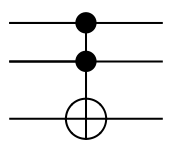

Toffoli-portti siis pyörittää kohdekubittia 180°, jos molemmat ohjaavat kubitit ovat $1$ tilassa. Sen unitaarinen matriisi on esimerkiksi

$$
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0
\end{bmatrix}
$$

> Huomaa että matriisin tarkka arvo riippuu kubittien järjestyksestä. Toffolin kontrollikubittien järjestyksellä ei ole merkitystä

Esimerkkejä portin toiminnasta:

$$
CCX |{000}\rangle = |{000}\rangle \\
CCX |{011}\rangle = |{011}\rangle \\
CCX |{101}\rangle = |{101}\rangle \\
CCX |{110}\rangle = |{111}\rangle \\
CCX |{111}\rangle = |{110}\rangle \\
$$

Voidaan huomata, että kohdekubitin (kolmannen) tila muuttuu ainoastaan ohjaavien kubittien (kahden ensimmäisen) ollessa $|1\rangle$.

### Miten Toffoli-portti luodaan?

Toffoli-portti voidaan luoda muiden porttien yhdistelmänä. Suorita seuraava koodilohko, joka luo yhtä Toffoli-porttia vastaavan piirin ja tulostaa sen unitaarisen matriisin.

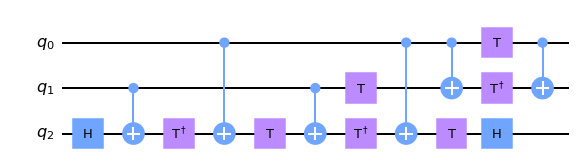

Yllä olevan kvanttipiirin unitaarinen matriisi


<IPython.core.display.Latex object>

Oikea Toffoli-portti referenssinä


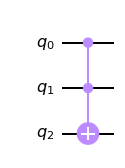

Yllä olevan kvanttipiirin unitaarinen matriisi


<IPython.core.display.Latex object>

In [14]:
backend = Aer.get_backend('unitary_simulator')

qc = QuantumCircuit(3)

qc.h(2)
qc.cx(1, 2)
qc.tdg(2)
qc.cx(0, 2)
qc.t(2)
qc.cx(1, 2)
qc.tdg(2)
qc.cx(0, 2)
qc.t(2)
qc.t(1)
qc.cx(0, 1)
qc.h(2)
qc.t(0)
qc.tdg(1)
qc.cx(0, 1)

display(qc.draw(output='mpl'))
U = backend.run(qc).result().get_unitary(qc, decimals=3)

print('Yllä olevan kvanttipiirin unitaarinen matriisi')
display(array_to_latex(U))

print('Oikea Toffoli-portti referenssinä')

# luodaan uusi piiri
qc = QuantumCircuit(3)

# tekee X-operaation 2 kubittiin jos kubitit 0 ja 1 ovat |1
qc.ccx(0, 1, 2)

display(qc.draw(output='mpl'))
U = backend.run(qc).result().get_unitary(qc, decimals=3)

print('Yllä olevan kvanttipiirin unitaarinen matriisi')
display(array_to_latex(U))

> Huomaa, että matriisi ei ole sama kuin aikaisemmin mainittu Toffolin matriisi. Tämä johtuu sittä, että qiskit listaa kubitit alhaalta ylös, eli ensimmäinen kubitti onkin kohdekubitti. Vaikka matriisi ei ole sama, on tämäkin matriisi Toffolin yksi matriisiesitys.

Tuloksista voidaan huomata, että Toffolin, joka on kolmen kubitin operaatio, voi esittää piirillä, joka koostuu vain yhden ja kahden kubitin operaatioista.

## Diagonaalit: $CCX$-portti

Toffoli-portilla voimme ratkaista ongelmamme viimeisen osan: _onko samalla diagonaalilla korkeintaan yksi kuningatar?_ Esimerkiksi $2×2$ shakkilaudalla kaikki diagonaaleilla olevat ruutuparit voidaan piirtää seuraavasti:

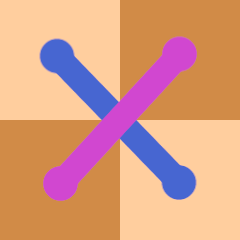

Eli kubitit $\text{row0}_0$ ja $\text{row1}_1$ muodostavat yhden diagonaaliparin ja $\text{row1}_0$ ja $\text{row0}_1$ muodostavat toisen. Nämä voidaan tarkistaa kahdella Toffolilla ja kahdella apukubitilla

### Tehtävä 4

Lisää seuraavaan kvanttipiiriin puuttuva Toffoli, joka flippaa $\text{diag}_1$-apukubitin jos yllä olevan kuvan pinkillä diagonaalilla on kaksi kuningatarta.

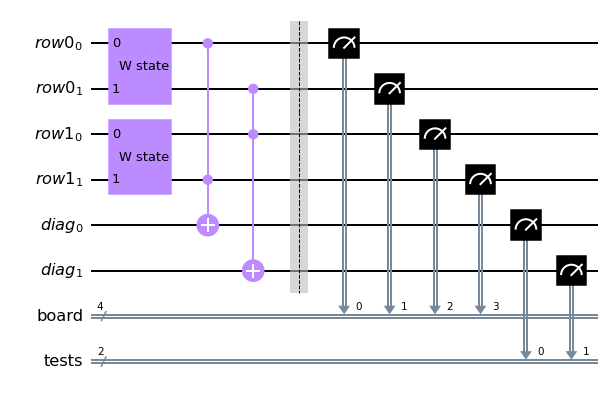

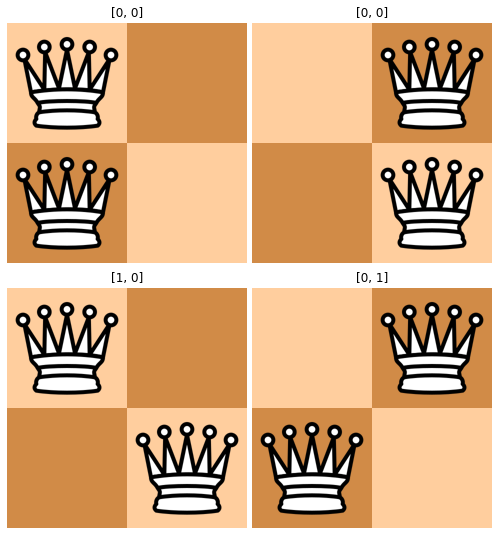

In [19]:
qc = QuantumCircuit()

rows = []
for n in range(2):
    row = QuantumRegister(2, f'row{n}')
    rows.append(row)
    # lisätään kvanttipiiriin N kpl N kubitin kvanttirekistereitä
    qc.add_register(row)

W = Wstate(2)
for row in rows:
    # lisätään W-alipiiri riville
    qc.append(W, row)

# lisätään diagonals-apukubitit
diagonals = QuantumRegister(2, 'diag')
qc.add_register(diagonals)

qc.ccx(rows[0][0], rows[1][1], diagonals[0])
# TODO lisää toinen Toffoli, joka flippaa diag1 apukubitin, jos pinkillä diagonaalilla on kaksi kuningatarta
qc.ccx(rows[1][0], rows[0][1], diagonals[1])

# lisätään visuaalinen erotus mittausta ennen
qc.barrier()

# shakkilaudan kubittien mittaus
board = ClassicalRegister(4, 'board')
qc.add_register(board)
qc.measure([q for row in rows for q in row], board)

# apukubittien mittaus
tests = ClassicalRegister(2, 'tests')
qc.add_register(tests)

# TODO mittaa `diagonals` kubitit `tests` rekisteriin
qc.measure(diagonals,tests)

# piirretään valmis kvanttipiiri
display(qc.draw(output='mpl'))

backend = AerSimulator(method='statevector')
result = backend.run(transpile(qc, backend)).result()

boards = []
tests = []
# täytetään boards ja tests lista mittaustuloksista
for state in get_rich_counts(result)[0]:
    tests.append(state['tests'])
    boards.append(array(state['board']).reshape(2, 2))

vis(boards, tests)

Kuvista voidaan huomata, että kuningatarten ollessa samalla diagonaalilla jokin apukubitti flipataan tilaan 1. Diagonaalikriteeri vaatisi siis että kaikista apukubiteista saadaan mittaukseksi 0.

### Diagonaalien optimointi

$3×3$ shakkilaudalla diagonaalit näyttävät tältä:

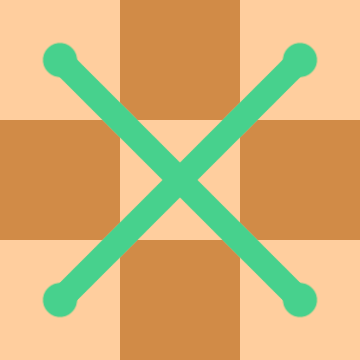 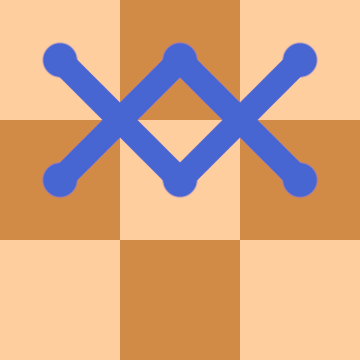 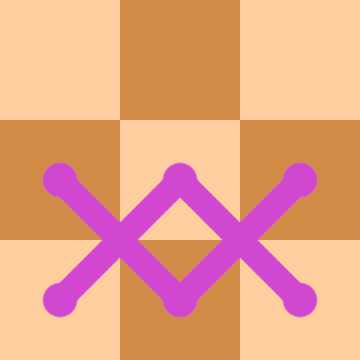

Kuvissa eri väreillä on esitetty diagonaaliparit, jotka voidaan yksiselitteisesti yhdistää samaan apukubittiin. Esimerkiksi sinivihreä kulmasta-kulmaan kuvan diagonaaliparit voidaan asettaa flippaamaan sama kubitti, sillä W-tilan takia samalla rivillä ei voi olla kahta kuningatarta, joten kubitti ei ikinä flippaa takaisin tilaan jossa diagonaalikonfliktia ei olisi.

Alla olevassa koodissa kvanttipiirissä flipataan diag-kubitit $X$-portilla, jotta tulos 1 vastaa oikeaa ratkaisua. Tämä on tavallaan turhaa, koska voisimme flipata klassisen tuloksen jälkikäteen ja säästää portteja.

### Tehtävä 5

Suorita seuraava N-kuningattaren kvanttialgoritmi, kun $N = 3$ ja totea lopputuloksista, että vastauksia ei ole. Muuta sitten $N = 4$ ja etsi lopputuloksista asetelma jonka yllä mitatut apukubitit ovat tilassa $[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]$. Jos et löydä kyseistä asetelmaa, voit laittaa `solution_filter` muuttujan päälle.

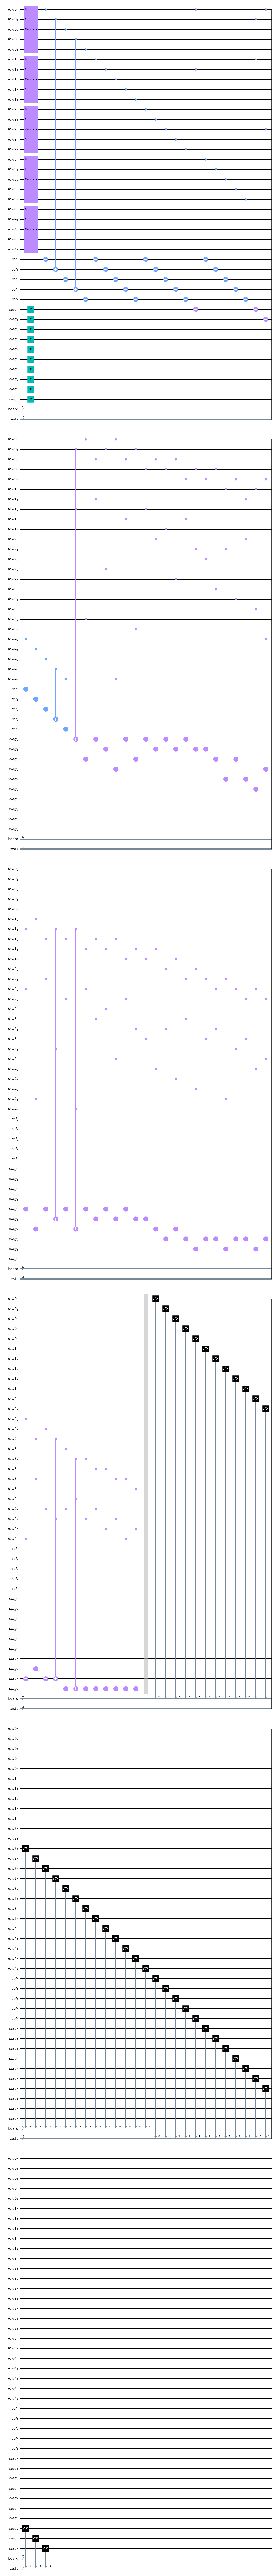

Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Insufficient memory to run circuit circuit-3022 using the statevector simulator.


QiskitError: 'ERROR:  [Experiment 0] Insufficient memory to run circuit circuit-3022 using the statevector simulator. ,  ERROR: Insufficient memory to run circuit circuit-3022 using the statevector simulator.'

In [23]:
qc = QuantumCircuit()

# katso ensiksi tulokset N = 3, sitten muuta N = 4
N = 5
# muuta solution_filter = True jos haluat nähdä vain oikeat asetelmat
solution_filter = True

rows = []
for n in range(N):
    row = QuantumRegister(N, f'row{n}')
    rows.append(row)
    # lisätään kvanttipiiriin N kpl N kubitin kvanttirekistereitä
    qc.add_register(row)

W = Wstate(N)
for row in rows:
    # lisätään W-alipiiri riville
    qc.append(W, row)

columns = QuantumRegister(N, 'col')
qc.add_register(columns)

for row in rows:
    # lisätään CX-portti jokaisen rivin kubitin ja sitä vastaavan columns apukubitin välille
    qc.cx(row, columns)

# lisätään diagonals-apukubitit
diagonals = QuantumRegister((N**2 - N)/2, 'diag')
qc.add_register(diagonals)

# asetetaan diagonals-apukubitit alkutilaan |1>, jotta oikeassa ratkaisussa kaikki apukubittien mittaustulokset ovat 1
qc.x(diagonals)

# käydään kaikki diagonaaliparit läpi
for i in range(1, N + 1):
    for j in range(i + 1, N + 1):
        for x in range(1, N + 1):
            for y in range(1, N + 1):
                if abs(i-j) == abs(x-y):
                    k = int((i-1)/2*(2*N-i))+j-i
                    q1 = rows[i-1][x-1]
                    q2 = rows[j-1][y-1]
                    qc.ccx(q1, q2, diagonals[k-1])

# lisätään visuaalinen erotus mittausta ennen
qc.barrier()

# shakkilaudan kubittien mittaus
board = ClassicalRegister(N**2, 'board')
qc.add_register(board)
qc.measure([q for row in rows for q in row], board)

# apukubittien mittaus
tests = ClassicalRegister(len(columns) + len(diagonals), 'tests')
qc.add_register(tests)
# mitataan columns-apukubitit ensimmäiseen N bittiin tests rekisterissä
qc.measure(columns, tests[:N])
# mitataan diagonals-apukubitit viimeiseen N bittiin tests rekisterissä
qc.measure(diagonals, tests[N:])

# piirretään valmis kvanttipiiri
display(qc.draw(output='mpl'))

backend = AerSimulator(method='statevector')
result = backend.run(transpile(qc, backend)).result()

boards = []
tests = []
# täytetään boards ja tests lista mittaustuloksista
for state in get_rich_counts(result)[0]:
    # jos solution_filter on epätosi tai kaikki testit meni läpi, lisätään asetelma ja testit listaan
    if not solution_filter or all(array(state['tests']) == 1):
        tests.append(state['tests'])
        boards.append(array(state['board']).reshape(N, N))

if len(boards) == 0:
    print("Ei ratkaisuja")
else:
    vis(boards, tests, numx = N, scale = 8/N, res = 30)

Kirjoita tähän montako ratkaisua N kuningattaren ongelmaan on:

$N=2$: 0 ratkaisua

$N=3$: TODO

$N=4$: TODO

## Lisämateriaalia

### Kvanttipiirin simulointi

Oletko kokeillut mitä käy kun laitat $N = 5$?

Neljän kuningattaren kvanttipiiri vaatii 26 kubittia, joka vaatii noin yhden gigatavun verran keskusmuistia tilavektorin esittämiselle. Viiden kuningattaren kvanttipiiri vaatisi 40 kubittia. 40 kubitin tilavektori vaatii yli 17 teratavua keskusmuistia!

### Klassinen algoritmi

N-kuningattaren klassinen ratkaisualgoritmi on eksponentiaalisesti hitaampi kuin yllä oleva kvanttialgoritmi. Klassisella tietokoneella ei pysty yli 30 kuningattaren ongelmaa ratkaisemaan järkevässä ajassa. On myös huomattava, että kvanttitietokoneella algoritmi vaatii erittäin paljon tarkkoja ja monimutkaisia portteja W-tilan luomiseksi.

In [25]:
from itertools import permutations

N = 10

dirs = [[1, 1], [-1, 1]]

def row_check(row):
    return row.sum() == 1

def diagonal_check(board, pos, dir):
    delta = pos + array(dir)
    while all(delta < board.shape) and all(delta >= 0):
        if board[delta[0], delta[1]]:
            return False
        delta += dir
    return True

basis = [[int(j == i) for j in range(N)] for i in range(N)]

all_boards = map(matrix, permutations(basis))

solutions = []
for board in all_boards:
    for i, q in enumerate(board.flat):
        if q:
            pos = unravel_index(i, (N, N))
            for dir in dirs:
                if not diagonal_check(board, pos, dir): break
            else:
                continue
            break
    else:
        solutions.append(board)

from queenvis import vis

vis(solutions, numx=4, res=60)

KeyboardInterrupt: 